In [1]:
import os
import re
import h5py
import numpy as np
import pandas as pd
import pickle as pkl
import multiprocessing
from copy import deepcopy

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

stopwords_dir = 'C:Users/philippe/AppData/Roaming/nltk_data/corpora/stopwords/'
# stopwords_dir = '~/nltk_data/corpora/stopwords'
files = os.listdir(stopwords_dir)
languages = [file for file in files if file != 'README']

stop_words = set()
for language in languages:
    stop_words.update(set(stopwords.words(language)))
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import StratifiedKFold, KFold

from imblearn.over_sampling import RandomOverSampler

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.utils import Sequence

Using TensorFlow backend.


# Preprocessing
## Combine song lyrics with genres

In [2]:
# df = pd.read_hdf('song-lyrics-genres.h5', key='df', mode='r')

In [21]:
# (df.lyrics.str.split().apply(len) > 82 + 43).sum() / df.shape[0]

# df_short = pd.DataFrame(columns=df.columns)
# song_lengths = df.lyrics.str.split().apply(len)
# avg_len = song_lengths.mean()
# std_len = song_lengths.std()
# max_len = int(avg_len + std_len)
# for i, row in df.iterrows():
#     song_lyrics = row.lyrics.split()
#     num_segs = 1 + (song_lengths[i] // max_len)
#     seg_len = song_lengths[i] // num_segs
#     for j in range(num_segs):
#         seg = ' '.join(song_lyrics[j * seg_len : (j + 1) * seg_len])
#         new_row = dict(band=row.band, song=row.song, lyrics=seg, genres=row.genres)
#         df_short = df_short.append(new_row, ignore_index=True)

# df_short.to_hdf('song-lyrics-genres-short.h5', key='df', mode='w')

In [2]:
df = pd.read_hdf('combined-data/song-lyrics-genres-short.h5', key='df', mode='r')

### Dataframe of top genre tags

In [3]:
unique_genres = []
for lst in df['genres'].tolist():
    for x in lst:
        if (x not in stop_words) and (not re.match('\-.*', x)) and (x not in unique_genres):
            unique_genres.append(x)
unique_genres.sort()

df_genres_full = pd.DataFrame(index=df.index, columns=unique_genres)
for genre in unique_genres:
    df_genres_full[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
df_genres_full['band'] = df['band'].copy()
df_genres_bands = df_genres_full.groupby('band').max()
df_genres_full.drop('band', axis=1, inplace=True)
top_genres = df_genres_full.columns[df_genres_full.mean(axis=0) > 0.15]
df_genres = df_genres_full[top_genres].copy()

In [13]:
pd.concat((df.lyrics, df_genres), 1).to_hdf('combined-data/lyrics-genres.h5', key='df')

In [4]:
top_genres

Index(['black', 'death', 'heavy', 'power', 'thrash'], dtype='object')

# Word2Vec model

### Create and save Word2Vec model

In [59]:
# sentences = df.lyrics.str.split().tolist()
# word2vec_model = Word2Vec(sentences, size=400, window=5, min_count=5, workers=multiprocessing.cpu_count())
# word2vec_model.save('word2vec.model')

### Load untrained model

In [60]:
# word2vec_model = Word2Vec.load('word2vec.model')
# word_vectors = word2vec_model.wv
# del word2vec_model

### Train and save trained model

In [12]:
# sentences_train = [doc.split() for doc in df.lyrics.values]
# word2vec_model = Word2Vec(sentences_train, size=400, window=3, min_count=20, workers=multiprocessing.cpu_count())
# word2vec_model.save('word2vec_train.model')

# Multi-label classification metrics

In [5]:
class MultiLabelClassification:

    def __init__(self, y_true, y_pred=None, y_pred_classes=None, labels=None, class_thresh=0.5):
        self.true = y_true
        if y_pred_classes is None and y_pred is not None:
            self.pred = y_pred
            y_pred_classes = np.zeros_like(self.pred, dtype=int)
            y_pred_classes[self.pred > class_thresh] = 1
        else:
            self.pred = None
        self.pred_classes = y_pred_classes
        self.n_samples, self.n_labels = y_true.shape
        if labels is not None:
            if len(labels) == self.n_labels:
                self.labels = np.array(labels)
            else:
                raise ValueError("length of labels and shape of y_true do not match")
        else:
            self.labels = np.arange(self.true.shape[1])

    @property
    def __intersection(self):
        return self.true * self.pred_classes

    @property
    def __union(self):
        return np.minimum(1, self.true + self.pred_classes)

    @property
    def accuracy_score(self):
        # Number of labels in common / overall labels (true and predicted)
        return np.nanmean(self.__intersection.sum(1) / self.__union.sum(1))

    @property
    def precision_score(self):
        # Proportion of predicted labels that are correct
        return np.nanmean(self.__intersection.sum(1) / self.pred_classes.sum(1))

    @property
    def recall_score(self):
        # Proportion of true labels that were predicted
        return np.nanmean(self.__intersection.sum(1) / self.true.sum(1))

    @property
    def f1_score(self):
        # Harmonic mean of precision_score and recall_score
        p = self.precision_score
        r = self.recall_score
        return 2 * (p * r) / (p + r)

    def confusion_matrix(self, label=None, label_idx=None):
        confusion_matrices = multilabel_confusion_matrix(self.true, self.pred_classes)
        if label is not None:
            return confusion_matrices[np.where(self.labels == label)[0][0]]
        elif label_idx is not None:
            return confusion_matrices[label_idx]
        else:
            return confusion_matrices

    def print_report(self, verbose=0):
        print("Multi-label classification report")
        print("Accuracy:   {:.2f}".format(self.accuracy_score))
        print("Precision:  {:.2f}".format(self.precision_score))
        print("Recall:     {:.2f}".format(self.recall_score))
        print("F1-score:   {:.2f}".format(self.f1_score))
        if verbose == 1:
            for label, matrix in zip(self.labels, self.confusion_matrix()):
                print("===\nLabel: {}".format(label))
                print(matrix)

In [6]:
def cross_validate_multilabel(X, y, estimator, feature_names=None, evaluation_metric=balanced_accuracy_score, n_splits=5, verbose=False):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    y_prob, y_valid = np.zeros(y.shape), np.zeros(y.shape)
    if feature_names is None:
        feature_names = [str(x) for x in range(y.shape[1])]
    for i, feature in enumerate(feature_names):
        if verbose:
            print("Training on feature '{}'".format(feature))
        scores = np.zeros(n_splits)
        confusion_matrices = np.zeros((n_splits, 2, 2))
        for j, (train_idx, valid_idx) in enumerate(kfold.split(X, y[:, i])):
            if verbose:
                print("Fold {}/{}".format(j + 1, n_splits))
            X_fold_train, y_fold_train = X[train_idx], y[train_idx, i]
            X_fold_valid, y_fold_valid = X[valid_idx], y[valid_idx, i]
            estimator_ = deepcopy(estimator)
            estimator_.fit(X_fold_train, y_fold_train)
            try:
                y_fold_prob = estimator_.predict_proba(X_fold_valid)[:, 1]
            except AttributeError:
                y_fold_prob = estimator_.predict(X_fold_valid).reshape(-1)
            y_prob[valid_idx, i] = y_fold_prob
            y_valid[valid_idx, i] = y_fold_valid
            y_fold_pred = y_fold_prob.round()
            scores[j] = evaluation_metric(y_fold_valid, y_fold_pred)
            confusion_matrices[j] = confusion_matrix(y_fold_valid, y_fold_pred)
        if verbose:
            print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
            print("Average confusion matrix:")
            print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)
    return MultiLabelClassification(y_valid, y_prob)

In [7]:
def plot_roc_curve(true, prob, labels):
    plt.figure(figsize=(8, 6))
    auc = []
    for i, label in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(true[:, i], prob[:, i])
        auc.append(roc_auc_score(true[:, i], prob[:, i]))
        plt.step(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.gca().set_aspect('equal')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("ROC curve", size=20)
    plt.xlabel("False positive rate", size=16)
    plt.ylabel("True positive rate", size=16)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(alpha=0.5)
    plt.show()
    return auc

# Convolutional Neural Network

In [8]:
def create_keras_model(embedding_matrix, input_length, nb_classes=1, conv_nb_filters=(64,), conv_kernel_size=(5,), fc_size=(64,)):
    keras_model = Sequential()
    keras_model.add(layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=input_length, trainable=False))
    if len(conv_nb_filters) != len(conv_kernel_size):
        raise ValueError("n_conv_filters and conv_size must be same length")
    for nb_filters, kernel_size in zip(conv_nb_filters, conv_kernel_size):
        keras_model.add(layers.Conv1D(nb_filters, kernel_size, activation='relu'))
        keras_model.add(layers.MaxPooling1D(2))
    keras_model.add(layers.Flatten())
    for fc_size_ in fc_size:
        keras_model.add(layers.Dense(fc_size_, activation='relu'))
    keras_model.add(layers.Dense(nb_classes, activation='sigmoid'))
    keras_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return keras_model


class BatchGenerator(Sequence):

    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_X = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_X, batch_y

### Cross-validation training

In [9]:
def preprocess_data(corpus_train, corpus_valid, word2vec_model=None, word_vectors=None):
    maxlen = max([len(doc.split()) for doc in corpus_train])
    word_vectors = get_word_vectors(word2vec_model=word2vec_model, word_vectors=word_vectors)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus_train)
    X_train = tokenizer.texts_to_sequences(corpus_train)
    X_valid = tokenizer.texts_to_sequences(corpus_valid)
    X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
    X_valid = pad_sequences(X_valid, maxlen=maxlen, padding='post')
    embedding_matrix = generate_word_embedding(tokenizer, word_vectors)
    return X_train, X_valid, embedding_matrix


def get_word_vectors(word2vec_model=None, word_vectors=None):
    if word2vec_model is not None:
        if isinstance(word2vec_model, str):
            if os.path.exists(word2vec_model):
                w2v = Word2Vec.load(word2vec_model)
            else:
                w2v = gensim_api.load(word2vec_model)
        else:
            w2v = word2vec_model
        word_vectors = w2v.wv
    elif word_vectors is not None:
        pass
    else:
        raise ValueError("must provide one of word2vec_model or word_vectors")
    return word_vectors


def generate_word_embedding(tokenizer, word_vectors):
    vocab_size = len(tokenizer.word_index) + 1
    vector_dim = word_vectors.vector_size
    embedding_matrix = np.zeros((vocab_size, vector_dim))
    for word, word_idx in tokenizer.word_index.items():
        try:
            embedding_vector = word_vectors[word]
        except KeyError:
            pass
        else:
            embedding_matrix[word_idx] = embedding_vector
    return embedding_matrix

Loading Word2Vec model
Performing 3-fold cross-validation
-----
CV fold 1/3
Epoch 1/20
33/33 [==============================] - 30s 915ms/step - loss: 0.5230 - binary_accuracy: 0.7816 - val_loss: 0.4511 - val_binary_accuracy: 0.7935
Epoch 2/20
33/33 [==============================] - 29s 884ms/step - loss: 0.4658 - binary_accuracy: 0.7961 - val_loss: 0.4298 - val_binary_accuracy: 0.7976
Epoch 3/20
33/33 [==============================] - 30s 922ms/step - loss: 0.4530 - binary_accuracy: 0.7949 - val_loss: 0.4262 - val_binary_accuracy: 0.8006
Epoch 4/20
33/33 [==============================] - 30s 899ms/step - loss: 0.4510 - binary_accuracy: 0.7979 - val_loss: 0.4230 - val_binary_accuracy: 0.7940
Epoch 5/20
33/33 [==============================] - 33s 991ms/step - loss: 0.4436 - binary_accuracy: 0.8008 - val_loss: 0.4106 - val_binary_accuracy: 0.7987
Epoch 6/20
33/33 [==============================] - 32s 973ms/step - loss: 0.4314 - binary_accuracy: 0.8031 - val_loss: 0.4284 - val_binary

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


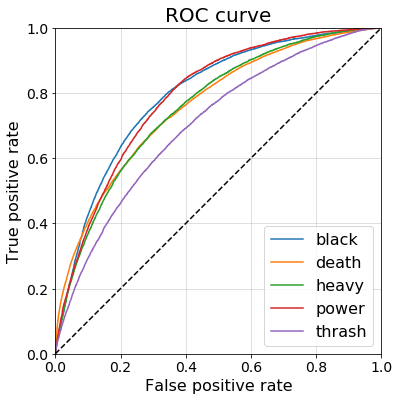

[0.7944531547863912, 0.7606307256776281, 0.7583146250255094, 0.7895089943434047, 0.7022603189966017]
AUC ROC score: 0.76 +/- 0.03


In [12]:
# Dataset
X = df.lyrics.values
y = df_genres.values
nb_classes = y.shape[1]

# Word2vec model
print("Loading Word2Vec model")
# word2vec_model = Word2Vec.load('word2vec_train.model')
# word_vectors = word2vec_model.wv
# del word2vec_model
word_vectors = KeyedVectors.load('glove-wiki-gigaword-300')

# Cross-validation
n_splits = 3
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=0)

# CNN model
model_params = dict(
    nb_classes=nb_classes,
    conv_nb_filters=(128, 128),
    conv_kernel_size=(4, 4),
    fc_size=(256,)
)

# Training
epochs = 20
batch_size = 1024

scores = np.zeros((n_splits, nb_classes))
confusion_matrices = np.zeros((n_splits, nb_classes, 2, 2))
results = []
print("Performing {}-fold cross-validation".format(n_splits))
for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
    print("-----\nCV fold {}/{}".format(i + 1, n_splits))
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    X_train, X_valid, embedding_matrix = preprocess_data(X_train, X_valid, word_vectors=word_vectors)
    keras_model = create_keras_model(embedding_matrix, X_train.shape[1], **model_params)
    train_generator  = BatchGenerator(X_train, y_train, batch_size)
    validation_generator = BatchGenerator(X_valid, y_valid, batch_size)
    keras_model.fit_generator(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)],
    )
    y_pred = keras_model.predict(X_valid)
    y_pred_classes = y_pred.round().astype(int)
    for j in range(nb_classes):
        scores[i, j] = balanced_accuracy_score(y_valid[:, j], y_pred_classes[:, j])
        confusion_matrices[i, j] = confusion_matrix(y_valid[:, j], y_pred_classes[:, j])
    results.append((y_valid, y_pred))
print("-----\nCross-validation complete")
print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)
true = np.concatenate([res[0] for res in results])
pred = np.concatenate([res[1] for res in results])
mlc = MultiLabelClassification(true, pred, labels=top_genres)
mlc.print_report()
auc_scores = plot_roc_curve(mlc.true, mlc.pred, mlc.labels)
print(auc_scores)
print("AUC ROC score: {:.2f} +/- {:.2f}".format(np.mean(auc_scores), np.std(auc_scores)))